In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm import utils
from timm.loss import JsdCrossEntropy, SoftTargetCrossEntropy, BinaryCrossEntropy, LabelSmoothingCrossEntropy
from timm import scheduler
from torch.optim import Adam
from sklearn.model_selection import train_test_split

import glob
from tqdm.notebook import tqdm
import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP
from PIL import Image
import torchvision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The model will be running on', device, 'device')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The model will be running on cuda:0 device


In [2]:
class BreastCancerDataset(Dataset):
    def __init__(self, data_path_file, train=True):
        super(Dataset, self).__init__()
        self.data = pd.read_csv(data_path_file,index_col=0)
        self.global_path = "/kaggle/input/meta-data/Data_image/"
        self.train = train
        if train:
            # Define the training data augmentation pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(224,224)),
#                 transforms.RandomResizedCrop(size=(384,384), scale=(0.8, 1), ratio=(0.45, 0.55)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(5),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),
                transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),

                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])
        else:
            # Define the validation and testing pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(224,224)),
#                 transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.data)
    def zero_mean_normalize_image(self, image):
        mean = np.mean(image)
        std = np.std(image)
        normalized_image = (image - mean) / std
        return normalized_image

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        label = row['status']
        dic = {0: 'Bengin', 1:'Mag' }
        if self.train:
            path_global = f'/kaggle/input/data-clahe/Train/Train/{dic[label]}/'
        else:
            path_global = f'/kaggle/input/data-clahe/Test/Test/{dic[label]}/'

#         print(os.path.basename(row['Image']).replace('.png', ''))
        row['Image'] = row['Image'].split("\\")[1]

        image_filename = row['Image'].replace('.png', '')
        name = f"{image_filename}_{row.roatation_120}_{row.roatation_240}_{row.clahe}.png"
        name = name.replace('\\', '/').replace('Benign Masses/', '').replace('Malignant Masses/', '')
        img_path = os.path.join(path_global, name)
        
#         image = cv2.imread(img_path)
#         if self.train == False:
#             image =getRecoverScene(image, refine=True)
        image = Image.open(img_path)
#         image = Image.fromarray(image)
        labels = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, labels, name
# Như vậy, bạn chỉ cần chuyển đổi ảnh xám đã xử lý thành đối tượng hình ảnh (Image) và sau đó áp dụng các biến đổi còn lại trong pipeline của bạn.

In [3]:
path_train = '/kaggle/input/data-clahe/train_aug.csv'
path_val = '/kaggle/input/data-clahe/test_aug.csv'


In [4]:
def check_exits(path, train=True):
    data = pd.read_csv(path)
    global_path = "/kaggle/input/meta-data/Data_image/"
    for idx in tqdm(data.index):
        row = data.iloc[idx]

        label = row['status']
        dic = {0: 'Bengin', 1: 'Mag'}
        if train:
            path_global = f'/kaggle/input/data-clahe/Train/Train/{dic[label]}/'
        else:
            path_global = f'/kaggle/input/data-clahe/Test/Test/{dic[label]}/'

#         print(os.path.basename(row['Image']).replace('.png', ''))
        row['Image'] = row['Image'].split("\\")[1]

        image_filename = row['Image'].replace('.png', '')
        name = f"{image_filename}_{row.roatation_120}_{row.roatation_240}_{row.clahe}.png"
        name = name.replace('\\', '/').replace('Benign Masses/', '').replace('Malignant Masses/', '')
        img_path = os.path.join(path_global, name)
        if not os.path.exists(img_path):
            print(img_path)


In [5]:
check_exits(path_train)
# "E:\Processing Data\Data_clahe\Train\Bengin\D3_D_4082_1.LEFT_MLO_0_0_0.png"
# /kaggle/input/ddsm-dataset/DDSM Dataset/DDSM Dataset/Malignant Masses/D1_A_1010_1.RIGHT_CC (2).png

  0%|          | 0/6558 [00:00<?, ?it/s]

/tmp/ipykernel_23/1961084751.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


In [6]:
check_exits(path_val, train=False)

  0%|          | 0/1095 [00:00<?, ?it/s]

/tmp/ipykernel_23/1961084751.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


In [7]:
# # Đường dẫn đến tệp văn bản bạn muốn đọc
# file_path = "/kaggle/input/data-clahe/description_False.txt"
# print(os.path.basename(file_path))
# # Mở tệp văn bản để đọc
# with open(file_path, 'r') as file:
#     # Duyệt qua từng dòng trong tệp và in ra
#     for line in file:
#         print(line.strip())  # strip() để loại bỏ ký tự xuống dòng (\n)

# # Sau khi vòng lặp kết thúc, tệp sẽ tự đóng


In [8]:
# # Đường dẫn đến tệp văn bản bạn muốn đọc
# file_path = "/kaggle/input/data-clahe/description_True.txt"
# print(os.path.basename(file_path))
# # Mở tệp văn bản để đọc
# with open(file_path, 'r') as file:
#     # Duyệt qua từng dòng trong tệp và in ra
#     for line in file:
#         print(line.strip())  # strip() để loại bỏ ký tự xuống dòng (\n)

# # Sau khi vòng lặp kết thúc, tệp sẽ tự đóng


In [9]:
print(''' Data from paper had custom''')

 Data from paper had custom


In [10]:
def infor(path, name):
    data = pd.read_csv(path)
    print(name)
    print(data.status.value_counts())
#     print(data.Type.value_counts())

In [11]:
infor(path_train, 'train')

train
1    3576
0    2982
Name: status, dtype: int64


In [12]:
infor(path_val, 'val')

val
1    597
0    498
Name: status, dtype: int64


In [13]:
# Tính toán trọng số cho mỗi lớp để cân bằng dữ liệu
def compute_class_weights(labels):
    class_frequencies = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (2.0 * class_frequencies)
    return class_weights

In [14]:
from torch.utils.data.sampler import WeightedRandomSampler
# Tạo DataLoader cho dữ liệu đã cân bằng
def create_balanced_dataloader(path_train, batch_size):
    dataframe = pd.read_csv(path_train)
    class_counts = dataframe.status.value_counts()
    class_weights = 1/class_counts
    sample_weights = [1/class_counts[i] for i in dataframe.status.values]
    train_dataset = BreastCancerDataset(path_train,train=True)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)
    dataloader = DataLoader(train_dataset,batch_size=batch_size, sampler=sampler)

    return dataloader

In [15]:
# train_dataset = BreastCancerDataset(path_train,train=True)
val_dataset = BreastCancerDataset(path_val,train=False)
# test_dataset_DDSM = BreastCancerDataset(path_test_DDSM,train=False)
# train_dataset = BreastCancerDataset(path_train,train=True)
# val_dataset = BreastCancerDataset(path_val,train=False)

In [16]:
batch_size = 64
# train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
# test_loader_DDSM = DataLoader(test_dataset_DDSM,batch_size=batch_size,shuffle=True)

train_loader = create_balanced_dataloader(path_train, batch_size)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [17]:
# batch_size = 64
# train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
# # test_loader_DDSM = DataLoader(test_dataset_DDSM,batch_size=batch_size,shuffle=True)

In [18]:
def save_model(config, epochs, model, optimizer, criterion, pretrained="True"):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"/kaggle/working/{config.model}_{epochs}.pth")
    print(f'Save model --> {config.model}_{epochs}.pth')

In [19]:
def apply_softmax(y_preds):
    softmax_preds = F.softmax(y_preds, dim=1)
    return softmax_preds

In [20]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, config, f1_scores, epochs, model, optimizer, criterion, pretrained="True"):

        score = f1_scores

        if self.best_score is None:
            self.best_score = score
            save_model(config, epochs, model, optimizer, criterion, pretrained="True")
        elif score <= self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            save_model(config, epochs, model, optimizer, criterion, pretrained="True")
            self.counter = 0

In [21]:
def validate(
        model,
        loader,
        loss_fn,
        config,
        device=torch.device('cuda'),
        amp_autocast=suppress,
        log_suffix='',
        data_name = "val"
):  

    model.eval()
    label_list = []
    label_pred_list = []
    last_idx = len(loader) - 1
    val_loss = .0
    val_acc = .0
    f1_scr = .0
    with torch.no_grad():
        for batch_idx, (inputs, target, name) in enumerate(loader):
#             label = target
            target = F.one_hot(target, config.num_classes)
            
            inputs = inputs.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float )

            with amp_autocast():
                output = model(inputs)
                if isinstance(output, (tuple, list)):
                    output = output[0]
                

            loss = loss_fn(output, target)

            val_loss += loss.item()
            output = apply_softmax(output)

            predicted = torch.max(output, 1)[1].to(device)
            label = torch.max(target, 1)[1].to(device)
            label_list.append(label.cpu())
            label_pred_list.append(predicted.cpu())

    # Tính toán độ chính xác cho toàn bộ tập dữ liệu validation
    label_list = np.concatenate([labels.numpy() for labels in label_list])
    label_pred_list = np.concatenate([preds.numpy() for preds in label_pred_list])
    val_acc = np.sum(label_list == label_pred_list) / len(label_list)
#     print(label_list)
    # Tính toán F1 score
    f1_scr = f1_score(label_list, label_pred_list, average='weighted')

    metrics = {
        "data": data_name,
        "acc": round(val_acc, 3),
        "loss": round(val_loss / len(loader), 3),  # Chia cho số lượng batch để tính trung bình
        "f1": round(f1_scr, 3)
    }
#     print(metrics)
    return metrics

In [22]:
def train_one_epoch(
        epoch,
        model,
        loader,
        optimizer,
        loss_fn,
        device=torch.device('cuda'),
        lr_scheduler=None,
        saver=None,
        output_dir=None,
        amp_autocast=suppress,
        loss_scaler=None,
        model_ema=None,
        mixup_fn=None,
        config=None
):
    losses_m = utils.AverageMeter()
    model.train()
    '''
    scaler: là một phần của tích hợp đào tạo dựa trên tự động hỗ trợ (Automatic Mixed Precision - AMP) trong PyTorch. 
    AMP là một kỹ thuật giúp tăng tốc độ đào tạo và giảm bộ nhớ sử dụng bằng cách sử dụng kiểu dữ liệu có độ chính xác thấp (float16)
    cho tính toán gradient và tự động chuyển đổi về kiểu dữ liệu cao hơn (float32) khi cần thiết để tránh tràn số và
    giảm thiểu sai số tính toán.
    AMP trong PyTorch sử dụng phép chia tỷ lệ gradient (gradient scaling) để tránh tràn số.
    Khi thực hiện lan truyền ngược (backpropagation), gradient được tính toán dựa trên kiểu dữ liệu float16. 
    Trong quá trình cập nhật trọng số, torch.cuda.amp.GradScaler sẽ điều chỉnh gradient sao cho giá trị của gradient 
    không bị tràn số. Nếu gradient quá lớn, nó sẽ được scale về mức an toàn để tránh tràn số khi cập nhật trọng số.
    '''
    scaler = torch.cuda.amp.GradScaler(enabled=config.apex)
    dataset_size = 0
    running_loss = 0.0
    num_batches_per_epoch = len(loader)
    num_updates = epoch * num_batches_per_epoch
    label_list = []
    label_pred_list = []
    last_idx = len(loader) - 1
    val_acc = .0     
    cnt = []
    for batch_idx, (inputs, target, name) in tqdm(enumerate(loader), total=num_batches_per_epoch):         
#         count_per_class = torch.bincount(target, minlength=2)
#         print(count_per_class)
#         cnt.append([count_per_class[0].item(), count_per_class[1].item()])
        target = F.one_hot(target, config.num_classes)
        
        inputs = inputs.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float )
        with torch.cuda.amp.autocast(enabled=config.apex):
            output = model(inputs)
        loss = loss_fn(output, target)
        
        # đặt tất cả gradient của các tham số về 0, 
        optimizer.zero_grad()
        # Cập nhật giá trị, lưu trữ hàm loss lại
        losses_m.update(loss.item(), inputs.size(0))
        
        
        
        # Thực hiện propagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        "Validation"
        
        output = apply_softmax(output)
                
        predicted = torch.max(output, 1)[1].to(device)
        label = torch.max(target, 1)[1].to(device)
#         print(predicted)
        label_list.append(label.cpu())
        label_pred_list.append(predicted.cpu())
        
        if model_ema is not None:
            model_ema.update(model)
        '''
        torch.cuda.synchronize() là một hàm trong PyTorch được sử dụng để đồng bộ hóa việc thực hiện các phép tính trên GPU. Khi ta thực hiện các phép tính trên GPU, các lệnh được gửi tới GPU để thực hiện là bất đồng bộ, điều này có nghĩa là Python sẽ tiếp tục thực hiện các lệnh tiếp theo mà không chờ GPU hoàn thành phép tính. Điều này tạo ra một chút "trễ" (latency) giữa việc gửi các lệnh tính toán đến GPU và thực tế thực hiện các phép tính trên GPU.
        '''
        torch.cuda.synchronize()
        
        num_updates += 1
        '''
        : lr_scheduler là một đối tượng hoặc lớp chịu trách nhiệm điều chỉnh tốc độ học (learning rate) của bộ tối ưu hóa trong quá trình huấn luyện. Tốc độ học quyết định tốc độ mà các trọng số của mô hình được cập nhật trong quá trình huấn luyện.
        '''
        if lr_scheduler is not None:
            lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)
        if hasattr(optimizer, 'sync_lookahead'):
            optimizer.sync_lookahead()
    # Tính toán độ chính xác cho toàn bộ tập dữ liệu validation
    label_list = np.concatenate([labels.numpy() for labels in label_list])
    label_pred_list = np.concatenate([preds.numpy() for preds in label_pred_list])
    val_acc = np.sum(label_list == label_pred_list) / len(label_list)
    f1_scr = f1_score(label_list, label_pred_list, average='weighted')
    metrics = {
        "data": "train",
        "acc": val_acc,
        "loss": losses_m.avg,  # Chia cho số lượng batch để tính trung bình
        "f1": f1_scr
    }
#     print(cnt)
    return metrics


In [23]:
class focal_loss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2, reduction: str = "none"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        """
        Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
        Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

        Args:
            inputs: A float tensor of arbitrary shape.
                    The predictions for each example.
            targets: A float tensor with the same shape as inputs. Stores the binary
                    classification label for each element in inputs
                    (0 for the negative class and 1 for the positive class).
            alpha: (optional) Weighting factor in range (0,1) to balance
                    positive vs negative examples or -1 for ignore. Default = 0.25
            gamma: Exponent of the modulating factor (1 - p_t) to
                   balance easy vs hard examples.
            reduction: 'none' | 'mean' | 'sum'
                     'none': No reduction will be applied to the output.
                     'mean': The output will be averaged.
                     'sum': The output will be summed.
        Returns:
            Loss tensor with the reduction option applied.
        """

#         if not torch.jit.is_scripting() and not torch.jit.is_tracing():
#             _log_api_usage_once(sigmoid_focal_loss)
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

In [24]:
class Parameter_model:
    def __init__(self):
        self.channels_last = None
        self.pretrained = False
        
        self.in_chans = 3
        self.num_classes = 2
        self.drop = 0.4
        self.drop_path = 0.2
        self.gp = 'max'
        self.num_epochs = 150

        self.lr = 0.000001
        self.grad_checkpointing = True
        self.channels_last = True
        '''
        vit_base_patch32_224.augreg_in21k_ft_in1k
        vit_large_patch16_224.augreg_in21k_ft_in1k
        efficientnetv2_s
        efficientnet_b0
        '''
        self.smoothing = 0.1
        self.min_lr = 5e-5
        self.warmup_epochs = 4
        self.warmup_lr =  3e-5
        self.eval_metric = 'loss'
        self.apex = True
        self.gem =False
        self.check_point = '/kaggle/input/checkpoint/efficientnet_b0_93.pth'
        
        self.channels_last = None
        self.pretrained = True
        self.in_chans = 3
        self.num_classes = 2

        self.model = "efficientnet_b0"
        self.min_lr = 5e-5
        self.warmup_epochs = 4
        self.warmup_lr =  3e-5
        self.eval_metric = 'loss'
        self.apex = True
        self.gem =True
        self.loss = None
        self.alpha = 0.25
        self.gamma = 2
        self.reduction = 'mean'
        self.loss = None
        self.gem = False
        self.path_checkpoint  = '/kaggle/input/checkpoint/efficientnet_b0_93.pth'

In [25]:
class mode_gem(nn.Module):    
    def __init__(self, features, pool, in_features):
        super(mode_gem, self).__init__()
        self.features = nn.Sequential(*features)
        self.fc = nn.Linear(in_features, 2)
        self.pool = pool
    
    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        o = self.fc(o)
        return o
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
def create_model_gem(config):
    models_b4 = timm.create_model(
        config.model,
        pretrained=config.pretrained,
        in_chans=config.in_chans,
        num_classes=config.num_classes,
        drop_rate=config.drop,
        drop_path_rate=config.drop_path,
        global_pool=config.gp
    )
    if 'vit' in config.model:
        return models_b4
    in_features  = None
    if "convnet" in config.model or "vit" in config.model: 
        in_features  = models_b4.head.in_features    # cho convnet 
    else :
        in_features  = models_b4.classifier.in_features # cho eff
    features = list(models_b4.children())[:-2]
    pool = GeM()
    model_pool = mode_gem(features, pool, in_features)
    return model_pool

In [26]:
info_epoch = pd.DataFrame(columns=["epoch", "train_loss", "train_acc",  "f1-train", "val_acc","val_loss", "f1-val"])

In [27]:
import torchvision.models as models


In [28]:
def train (config):
    in_chans = 3 # số kênh đầu vào
    # [epoch, train_metrics['acc'], train_metrics['loss'], train_metrics['f1'], eval_metrics['acc'], eval_metrics['loss'], eval_metrics['f1'], path]
    print(f"############### Mode {config.model}  ###############")
    print(f'Gem : {config.gem }')
    if config.gem:
        model = create_model_gem(config)
    else:
        if config.model == 'efficientnet_v2_s':
            model = models.efficientnet_v2_s(
                weights='IMAGENET1K_V1', 
    #             num_classes=2,
    #             drop_rate=config.drop,
    #             drop_path_rate=config.drop_path
            )
            for param in model.parameters():
                param.requires_grad = False
            output_shape  = 2
            # Recreate the classifier layer and seed it to the target device
            model.classifier = torch.nn.Sequential(
                torch.nn.Dropout(p=0.2, inplace=True), 
                torch.nn.Linear(in_features=1280, 
                                out_features=output_shape, # same number of output units as our number of classes
                                bias=True)).to(device)
        else:
            model = timm.create_model(
                config.model,
                pretrained=config.pretrained,
    #             in_chans=config.in_chans,
                num_classes=config.num_classes,
                drop_rate=config.drop,
                drop_path_rate=config.drop_path,
    #             act_layer = nn.GELU
    #             global_pool=config.gp
            )

    # if config.grad_checkpointing:
    #     model.set_grad_checkpointing(enable=True)
    # move model to GPU, enable channels last layout if set
    
    model.to(device=device)

    optimizer = create_optimizer_v2(
        model,
        opt = 'AdamW',
        lr = config.lr,
        weight_decay=0.05,
        eps=1e-08
    )
     # setup automatic mixed-precision (AMP) loss scaling and op casting
    amp_autocast = suppress  # do nothing
    loss_scaler = None
    amp_dtype = torch.float16
    amp_autocast = partial(torch.autocast, device_type=device.type, dtype=amp_dtype)

    # setup exponential moving average of model weights
#     ema_model = utils.ModelEmaV2(model, decay=0.98)
    if config.loss =='fl':
        print("Apply Focal Loss")
        train_loss_fn = focal_loss(config.alpha, config.gamma, config.reduction).to(device=device)
    else:
#         train_loss_fn = LabelSmoothingCrossEntropy(smoothing=config.smoothing).to(device=device)
        train_loss_fn = nn.BCEWithLogitsLoss().to(device=device)
    validate_loss_fn = nn.BCEWithLogitsLoss().to(device=device)
#     validate_loss_fn = LabelSmoothingCrossEntropy(smoothing=config.smoothing).to(device=device)

    #train_loss_fn = nn.CrossEntropyLoss().to(device=device)
    # setup learning rate schedule and starting epoch
#     updates_per_epoch = len(train_loader)
#     num_epoch_repeat = config.num_epochs/2 
    num_epochs = config.num_epochs
#     lr_scheduler = timm.scheduler.CosineLRScheduler(
#         optimizer,
#         t_initial=config.num_epochs+10,
#         cycle_decay=0.5,
#         lr_min=1e-6,
#         t_in_epochs=True,
#         warmup_t=3,
#         warmup_lr_init=1e-4,
#         cycle_limit=1
#     )
    lr_scheduler = None
    start_epoch = 0
    if config.check_point != None:
        checkpoint = torch.load(config.check_point)
        model.load_state_dict(checkpoint['model_state_dict'])

        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        start_epoch = checkpoint['epoch'] +1
    best_model = .0
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=16, verbose=True)
    for epoch in tqdm(range(start_epoch, num_epochs)):
            
        train_metrics = train_one_epoch(
            epoch=epoch,
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            loss_fn=train_loss_fn,
#             lr_scheduler=lr_scheduler,
            amp_autocast=amp_autocast,
#             model_ema=ema_model,
            config = config
        )

        

        eval_metrics = validate(
        
            model,
            val_loader,
            validate_loss_fn,
            config=config,
            amp_autocast=amp_autocast,
            data_name="val"
        )
#         train_metrics = validate(
        
#             model,
#             train_loader,
#             train_loss_fn,
#             config=config,
#             amp_autocast=amp_autocast,
#             data_name="train"
#         )
#         print(train_metrics)
        early_stopping(config, eval_metrics['f1'], epoch, model, optimizer, train_loss_fn)
        if early_stopping.early_stop:
            print("Early stopping")
            break
#         if eval_metrics['f1'] > best_model:
#             best_model = eval_metrics['f1']
            
#             path = save_model(epoch, model, optimizer, train_loss_fn)
#             print(path)
    
        print(f"Epoch: {epoch}")
        print(f"loss train: {train_metrics['loss']}  loss val: {eval_metrics['loss']}")
        print(f"acc train: {train_metrics['acc']}  acc val: {eval_metrics['acc']} ")
        print(f"f1-train: {train_metrics['f1']}   f1-val: {eval_metrics['f1']}")
        # "epoch", "train_loss", "train_acc",  "f1-train", "val_acc","val_loss", "f1-val", "path"]
        info_epoch.loc[epoch] = [epoch,   train_metrics['loss'], train_metrics['acc'], train_metrics['f1'], eval_metrics['acc'], eval_metrics['loss'], eval_metrics['f1']]
        
#         values = np.array([train_loss, eval_metrics['loss'], eval_metrics['acc'], eval_metrics['f1']])

#         if np.isnan(values).any():
#             info_epoch.to_csv('/kaggle/working/info_epoch.csv')
#             return 0
        
        if lr_scheduler is not None:
            # step LR for next epoch
            lr_scheduler.step(epoch + 1, eval_metrics[config.eval_metric])
        info_epoch.to_csv('/kaggle/working/info_epoch.csv')
    

In [29]:
train(Parameter_model())

############### Mode efficientnet_b0  ###############
Gem : False


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_94.pth
Epoch: 94
loss train: 0.28160504459171404  loss val: 0.165
acc train: 0.9400731930466606  acc val: 0.956 
f1-train: 0.9400727959220347   f1-val: 0.956


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_95.pth
Epoch: 95
loss train: 0.29327639665644356  loss val: 0.146
acc train: 0.9367185117413845  acc val: 0.96 
f1-train: 0.9367164149509078   f1-val: 0.96


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 96
loss train: 0.25745979976675865  loss val: 0.165
acc train: 0.9472400121988411  acc val: 0.954 
f1-train: 0.9472392317715375   f1-val: 0.954


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 2 out of 16
Epoch: 97
loss train: 0.2519826755977397  loss val: 0.204
acc train: 0.9443427874351936  acc val: 0.945 
f1-train: 0.9443438163374573   f1-val: 0.945


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 3 out of 16
Epoch: 98
loss train: 0.25858034851548145  loss val: 0.175
acc train: 0.9422079902409272  acc val: 0.952 
f1-train: 0.9422090667990543   f1-val: 0.952


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 4 out of 16
Epoch: 99
loss train: 0.2653564606526524  loss val: 0.152
acc train: 0.9470875266849649  acc val: 0.958 
f1-train: 0.9470906705215141   f1-val: 0.958


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_100.pth
Epoch: 100
loss train: 0.2184504547763358  loss val: 0.149
acc train: 0.9554742299481549  acc val: 0.962 
f1-train: 0.9554740767033957   f1-val: 0.962


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 101
loss train: 0.21501896716029442  loss val: 0.147
acc train: 0.9557792009759073  acc val: 0.962 
f1-train: 0.955779966241158   f1-val: 0.962


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_102.pth
Epoch: 102
loss train: 0.23160984166041493  loss val: 0.129
acc train: 0.9516620921012504  acc val: 0.967 
f1-train: 0.951662661961474   f1-val: 0.967


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_103.pth
Epoch: 103
loss train: 0.21310716677376432  loss val: 0.112
acc train: 0.9568465995730405  acc val: 0.974 
f1-train: 0.9568467350315272   f1-val: 0.974


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_104.pth
Epoch: 104
loss train: 0.21590768283880057  loss val: 0.124
acc train: 0.9574565416285453  acc val: 0.975 
f1-train: 0.9574582343095824   f1-val: 0.975


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 105
loss train: 0.19415773024266178  loss val: 0.135
acc train: 0.9606587374199451  acc val: 0.965 
f1-train: 0.960657782339531   f1-val: 0.965


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_106.pth
Epoch: 106
loss train: 0.2172339372234615  loss val: 0.112
acc train: 0.9545593168648978  acc val: 0.977 
f1-train: 0.95455759243538   f1-val: 0.977


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 107
loss train: 0.20120947380624338  loss val: 0.123
acc train: 0.9573040561146691  acc val: 0.973 
f1-train: 0.9573047113429248   f1-val: 0.973


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 2 out of 16
Epoch: 108
loss train: 0.18985871820233152  loss val: 0.113
acc train: 0.9646233607807259  acc val: 0.972 
f1-train: 0.9646228967549685   f1-val: 0.972


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 3 out of 16
Epoch: 109
loss train: 0.17995403039906221  loss val: 0.111
acc train: 0.9650808173223544  acc val: 0.974 
f1-train: 0.9650835147072582   f1-val: 0.974


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 4 out of 16
Epoch: 110
loss train: 0.19314162276364857  loss val: 0.103
acc train: 0.9621835925587069  acc val: 0.976 
f1-train: 0.9621855132232511   f1-val: 0.976


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 5 out of 16
Epoch: 111
loss train: 0.19748783307891316  loss val: 0.114
acc train: 0.9595913388228118  acc val: 0.974 
f1-train: 0.9595884773121166   f1-val: 0.974


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_112.pth
Epoch: 112
loss train: 0.1741652877483836  loss val: 0.096
acc train: 0.964775846294602  acc val: 0.981 
f1-train: 0.964776862831953   f1-val: 0.981


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 113
loss train: 0.19190850609430055  loss val: 0.115
acc train: 0.960506251906069  acc val: 0.97 
f1-train: 0.960507953989872   f1-val: 0.97


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 2 out of 16
Epoch: 114
loss train: 0.16089908224105898  loss val: 0.097
acc train: 0.9656907593778591  acc val: 0.978 
f1-train: 0.965696943338883   f1-val: 0.978


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 3 out of 16
Epoch: 115
loss train: 0.1675963694046241  loss val: 0.098
acc train: 0.9659957304056115  acc val: 0.981 
f1-train: 0.9659962214147644   f1-val: 0.981


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 4 out of 16
Epoch: 116
loss train: 0.16798586091387377  loss val: 0.086
acc train: 0.9637084476974688  acc val: 0.98 
f1-train: 0.9637094131169335   f1-val: 0.98


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_117.pth
Epoch: 117
loss train: 0.15741924933587026  loss val: 0.084
acc train: 0.9685879841415066  acc val: 0.984 
f1-train: 0.9685876043343414   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 118
loss train: 0.14690874070815285  loss val: 0.096
acc train: 0.9713327233912779  acc val: 0.984 
f1-train: 0.9713320619206244   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 2 out of 16
Epoch: 119
loss train: 0.16157267314699156  loss val: 0.077
acc train: 0.9652333028362305  acc val: 0.983 
f1-train: 0.9652340498186742   f1-val: 0.983


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 3 out of 16
Epoch: 120
loss train: 0.15242969567599765  loss val: 0.084
acc train: 0.9690454406831351  acc val: 0.981 
f1-train: 0.9690453435166737   f1-val: 0.981


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 4 out of 16
Epoch: 121
loss train: 0.15725407008900807  loss val: 0.071
acc train: 0.9675205855443733  acc val: 0.984 
f1-train: 0.967520189055521   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 5 out of 16
Epoch: 122
loss train: 0.14933318899476916  loss val: 0.093
acc train: 0.9679780420860018  acc val: 0.979 
f1-train: 0.9679781314343121   f1-val: 0.979


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 6 out of 16
Epoch: 123
loss train: 0.13480154167464245  loss val: 0.072
acc train: 0.9719426654467825  acc val: 0.984 
f1-train: 0.9719427802677341   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 7 out of 16
Epoch: 124
loss train: 0.13749117246303807  loss val: 0.075
acc train: 0.9717901799329064  acc val: 0.984 
f1-train: 0.971789847364637   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 8 out of 16
Epoch: 125
loss train: 0.13275770718057406  loss val: 0.083
acc train: 0.9710277523635255  acc val: 0.984 
f1-train: 0.9710272995911777   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 9 out of 16
Epoch: 126
loss train: 0.12378161490308907  loss val: 0.071
acc train: 0.9746874046965538  acc val: 0.984 
f1-train: 0.9746853226380779   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_127.pth
Epoch: 127
loss train: 0.14794974914828918  loss val: 0.063
acc train: 0.9678255565721257  acc val: 0.985 
f1-train: 0.9678255722825357   f1-val: 0.985


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_128.pth
Epoch: 128
loss train: 0.13516082693505993  loss val: 0.064
acc train: 0.9740774626410491  acc val: 0.987 
f1-train: 0.9740780991754349   f1-val: 0.987


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 129
loss train: 0.1220555154015357  loss val: 0.057
acc train: 0.9752973467520586  acc val: 0.985 
f1-train: 0.9752973950003615   f1-val: 0.985


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 2 out of 16
Epoch: 130
loss train: 0.12067081031229628  loss val: 0.07
acc train: 0.9762122598353157  acc val: 0.985 
f1-train: 0.9762139060334577   f1-val: 0.985


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 3 out of 16
Epoch: 131
loss train: 0.11949564256376156  loss val: 0.057
acc train: 0.9778896004879536  acc val: 0.985 
f1-train: 0.977890123490352   f1-val: 0.985


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 4 out of 16
Epoch: 132
loss train: 0.12333965976360405  loss val: 0.059
acc train: 0.9730100640439159  acc val: 0.985 
f1-train: 0.9730108290961744   f1-val: 0.985


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 5 out of 16
Epoch: 133
loss train: 0.11065343511326352  loss val: 0.052
acc train: 0.9752973467520586  acc val: 0.987 
f1-train: 0.9752975994829572   f1-val: 0.987


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 6 out of 16
Epoch: 134
loss train: 0.11433352696328455  loss val: 0.054
acc train: 0.9771271729185728  acc val: 0.986 
f1-train: 0.9771284830765294   f1-val: 0.986


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 7 out of 16
Epoch: 135
loss train: 0.10677613784565036  loss val: 0.045
acc train: 0.9778896004879536  acc val: 0.987 
f1-train: 0.9778891526537571   f1-val: 0.987


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 8 out of 16
Epoch: 136
loss train: 0.10189078162521119  loss val: 0.067
acc train: 0.9778896004879536  acc val: 0.984 
f1-train: 0.9778903012521885   f1-val: 0.984


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 9 out of 16
Epoch: 137
loss train: 0.102591776118914  loss val: 0.042
acc train: 0.9777371149740774  acc val: 0.987 
f1-train: 0.9777364916128327   f1-val: 0.987


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 10 out of 16
Epoch: 138
loss train: 0.09940648955821572  loss val: 0.052
acc train: 0.9791094845989631  acc val: 0.986 
f1-train: 0.9791087978508536   f1-val: 0.986


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 11 out of 16
Epoch: 139
loss train: 0.10224365286435903  loss val: 0.055
acc train: 0.9763647453491918  acc val: 0.986 
f1-train: 0.9763657989849027   f1-val: 0.986


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_140.pth
Epoch: 140
loss train: 0.10359507418325958  loss val: 0.053
acc train: 0.9780420860018298  acc val: 0.99 
f1-train: 0.9780429683588496   f1-val: 0.99


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 141
loss train: 0.09634252251135814  loss val: 0.042
acc train: 0.9804818542238487  acc val: 0.987 
f1-train: 0.9804813150160524   f1-val: 0.987


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 2 out of 16
Epoch: 142
loss train: 0.10139011563611089  loss val: 0.037
acc train: 0.9778896004879536  acc val: 0.988 
f1-train: 0.977889605114928   f1-val: 0.988


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 3 out of 16
Epoch: 143
loss train: 0.09168816693229405  loss val: 0.04
acc train: 0.9817017383348582  acc val: 0.989 
f1-train: 0.9817018915161984   f1-val: 0.989


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 4 out of 16
Epoch: 144
loss train: 0.0953154754121971  loss val: 0.034
acc train: 0.9788045135712108  acc val: 0.989 
f1-train: 0.9788043829616997   f1-val: 0.989


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 5 out of 16
Epoch: 145
loss train: 0.0977094669591439  loss val: 0.054
acc train: 0.9801768831960964  acc val: 0.986 
f1-train: 0.9801768831960964   f1-val: 0.986


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Save model --> efficientnet_b0_146.pth
Epoch: 146
loss train: 0.09481668545185415  loss val: 0.033
acc train: 0.9809393107654772  acc val: 0.993 
f1-train: 0.9809392544584759   f1-val: 0.993


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 1 out of 16
Epoch: 147
loss train: 0.0790792015012207  loss val: 0.031
acc train: 0.9830741079597438  acc val: 0.992 
f1-train: 0.9830747278707989   f1-val: 0.992


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 2 out of 16
Epoch: 148
loss train: 0.08339006041346181  loss val: 0.036
acc train: 0.9829216224458677  acc val: 0.99 
f1-train: 0.9829215970306344   f1-val: 0.99


  0%|          | 0/103 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]
/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


EarlyStopping counter: 3 out of 16
Epoch: 149
loss train: 0.08525733978292425  loss val: 0.035
acc train: 0.9818542238487343  acc val: 0.992 
f1-train: 0.9818541938887225   f1-val: 0.992


In [30]:
# info_epoch  =pd.read_csv('/kaggle/input/checkpoint/info_epoch.csv')

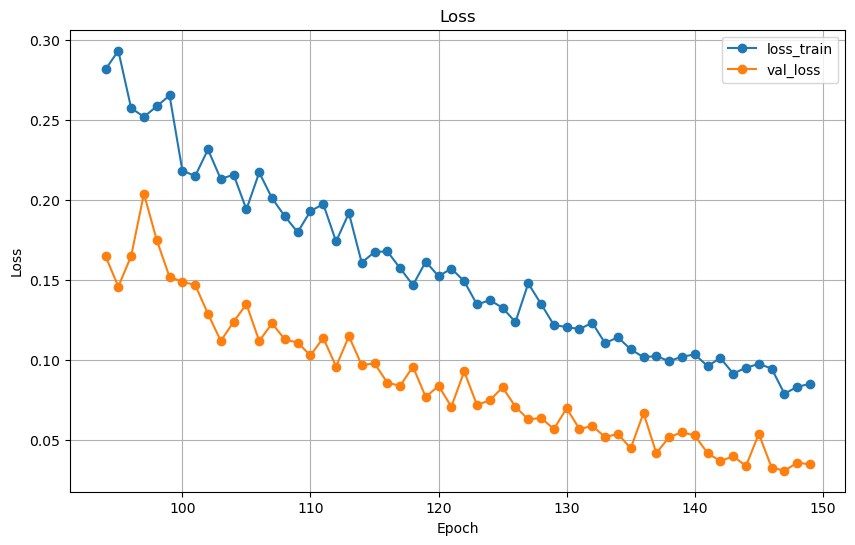

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(info_epoch['epoch'], info_epoch['train_loss'], label='loss_train', marker='o')
plt.plot(info_epoch['epoch'], info_epoch['val_loss'], label='val_loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('/kaggle/working/loss_vs_epoch.png')


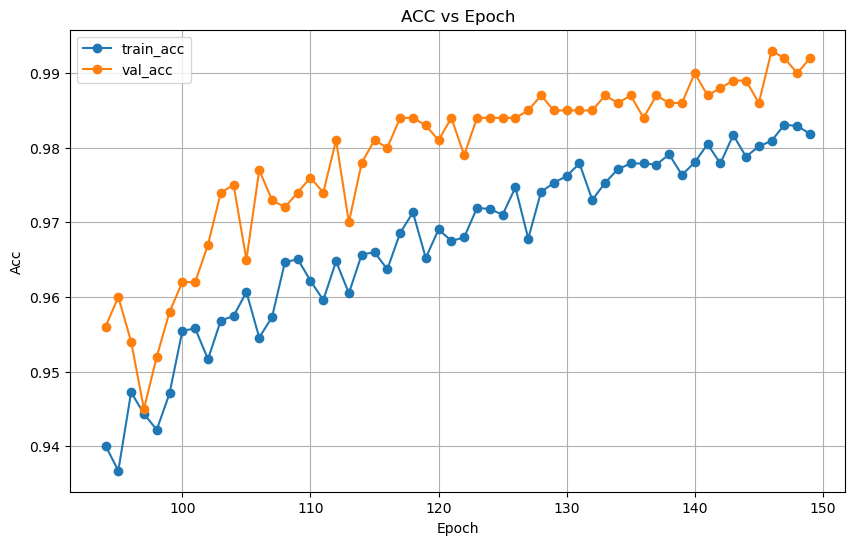

<Figure size 640x480 with 0 Axes>

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(info_epoch['epoch'], info_epoch['train_acc'], label='train_acc', marker='o')
plt.plot(info_epoch['epoch'], info_epoch['val_acc'], label='val_acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('ACC vs Epoch')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('/kaggle/working/accuracy_vs_epoch.png')


In [33]:
info_epoch.sort_values(by='f1-val', ascending=False)

,epoch,train_loss,train_acc,f1-train,val_acc,val_loss,f1-val
146,146.0,0.094817,0.980939,0.980939,0.993,0.033,0.993
149,149.0,0.085257,0.981854,0.981854,0.992,0.035,0.992
147,147.0,0.079079,0.983074,0.983075,0.992,0.031,0.992
140,140.0,0.103595,0.978042,0.978043,0.990,0.053,0.990
148,148.0,0.083390,0.982922,0.982922,0.990,0.036,0.990
144,144.0,0.095315,0.978805,0.978804,0.989,0.034,0.989
143,143.0,0.091688,0.981702,0.981702,0.989,0.040,0.989
142,142.0,0.101390,0.977890,0.977890,0.988,0.037,0.988
135,135.0,0.106776,0.977890,0.977889,0.987,0.045,0.987
137,137.0,0.102592,0.977737,0.977736,0.987,0.042,0.987


In [34]:
config = Parameter_model()

weight_best = info_epoch.sort_values(by='f1-val', ascending=False).iloc[0]

 
print(f"Best epoch {weight_best.epoch}")
print(weight_best)
# os.rename(weight_best.path, f'/kaggle/working/weight_best.pth')

Best epoch 146.0
epoch         146.000000
train_loss      0.094817
train_acc       0.980939
f1-train        0.980939
val_acc         0.993000
val_loss        0.033000
f1-val          0.993000
Name: 146, dtype: float64


In [35]:
checkpoint = torch.load(f"/kaggle/working/{config.model}_{int(weight_best.epoch)}.pth")
# checkpoint = torch.load('/kaggle/input/checkpoint/efficientnet_b0_97.pth')


In [36]:
best_model_state_dict = checkpoint['model_state_dict']
if config.gem: 
    model = create_model_gem(config)
else:
     model = timm.create_model(
            config.model,
            pretrained=config.pretrained,
#             in_chans=config.in_chans,
            num_classes=config.num_classes,
#             drop_rate=config.drop,
#             drop_path_rate=config.drop_path,
#             global_pool=config.gp
        )

model.load_state_dict(best_model_state_dict)
model.to(device=device)
x = 1

In [37]:
print(1)

1


  0%|          | 0/18 [00:00<?, ?it/s]

/tmp/ipykernel_23/3869583034.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Image'] = row['Image'].split("\\")[1]


Accuracy: 0.9908675799086758
Precision: 0.9908772188327386
Recall: 0.9908675799086758
F1 score: 0.9908690692039592
AUC normal: 0.9909588101148311
AUC benign: 0.9909588101148312


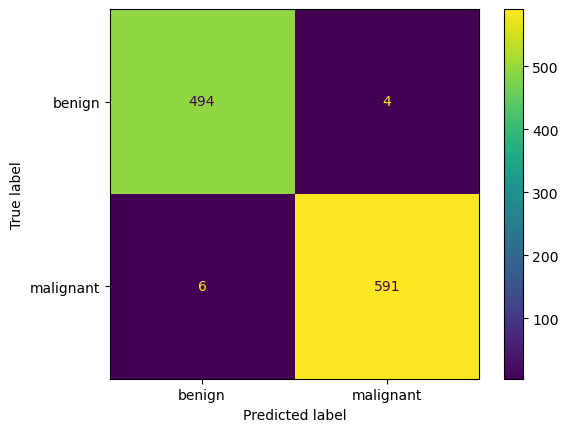

In [38]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score
model.eval()
with torch.no_grad():
    names = []
    y_true = []
    y_pred = []
    for (inputs, labels,name) in tqdm(val_loader):
#         names.append(name)
#         print(list(name))
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        model.to(device)
        outputs = model(inputs)
        outputs = apply_softmax(outputs)
#         print(outputs)
        predicted = torch.max(outputs,dim=1)[1]

        y_true += labels.tolist()
        y_pred += predicted.tolist()
        names += list(name)
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=3)
# auc_score = auc(fpr, tpr)

num_labels  =2
y_true_one_hot = np.eye(num_labels)[y_true]
y_pred_one_hot = np.eye(num_labels)[y_pred]
auc_scores = []
for label in range(num_labels):
    auc = roc_auc_score(y_true_one_hot[:, label], y_pred_one_hot[:, label])
    auc_scores.append(auc)

# print("AUC scores for each label:", auc_scores)



# print(f"Result {name_model}")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'AUC normal: {auc_scores[0]}')
print(f'AUC benign: {auc_scores[1]}')
# print(f'AUC malignant: {auc_scores[2]:.2f}')

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['benign','malignant'])
disp.plot()
plt.savefig('confusion_matrix_DDSM.png')
plt.show()